In [1]:
import cv2
import autograd.numpy as np
from autograd import grad
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from scipy.optimize import fmin_cg
from scipy.optimize import minimize
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.neighbors as neighbors

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
import numpy as np
from scipy.sparse.linalg import bicg, bicgstab
from scipy.signal import convolve2d

# from sklearn.neighbors import LSHForest

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

image ./resources/test4.png loaded
(300, 438)55117


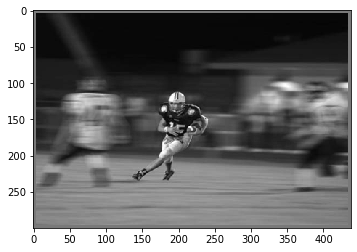

In [3]:
img = utils.loadImage('./resources/test4.png', 'gray')
# x, K = utils.nonUniformBlur(img)
magnitude, directions = reblur.getImageBlurEstimate(img)

x = img
print(x.shape)
plt.imshow(x, cmap='gray')

In [4]:
def downscale(x, alpha, show=False):
    '''
     @input: blurred img x
     @input: estimated kernel k

     @return: deblurred image
    '''


    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [5]:
from annoy import AnnoyIndex

class AnnoyKNN:
    def __init__(self, img, patch_size):
        self.image = img
        self.patch_size = patch_size
        self.feature_dims = patch_size*patch_size
        self.KNN = None
    
    def make_index(self, method):
        """
            make indices to be used for search in KNN
            patches are flatten and treated as 1D vectors
        """
        self.KNN = AnnoyIndex(self.feature_dims, method)
        img = utils.im2col(self.image, [self.patch_size, self.patch_size])
        for i in range(img.shape[1]):
            self.KNN.add_item(i, (img.T)[i,:])
            
    def build(self, n_trees):
        """
            specify the no. of trees to be used
            more trees -> higher accuracy, higher search time
        """
        self.KNN.build(n_trees)
        
    def get_nn(self, patch):
        """
            input patch to be searched
            returns the nearest patch from indices
        """
        nn = self.KNN.get_nns_by_vector(patch.flatten(), 1)
        nn = self.KNN.get_item_vector(nn[0])
        return (np.array(nn)).reshape((self.patch_size, self.patch_size))

In [6]:
"""
imrpove -> predict for the entire row at once, using njobs
intra image reccurence
"""

from annoy import AnnoyIndex
import random
import time


def getPriorPatch(patch, im_shape, cimg, h):
    k = patch.shape[0]
    
    num = np.zeros((k,k))
    denom = 0
    
    cpatch = patch.ravel()[:,None]
    
    prob = np.exp(-np.mean((cpatch - cimg)**2, axis=0)/(2*(h**2)))
    denom = np.sum(prob)
    num = cimg @ prob[:,None]
    num = num.reshape((k,k))
    
#     for i in range(k//2+1, n-k//2):
#         for j in range(k//2+1, m-k//2):
#             splice = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
#             err = np.mean((patch - splice)**2)
#             exp = -err/(2*(h**2))
            
#             p = np.exp(exp)
#             num += p * splice
#             denom += p
            
    return num/(denom*k*k)

def getPrior(img, patch_size, alpha, h, stride):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    @input h
    @input stride: not used
    
    @return z: size (n x m)
    """
    
    start = time.time()
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    KNN = AnnoyKNN(x_alpha, M)
    KNN.make_index('euclidean')
    KNN.build(200)
    

    # build NN model
#     cx_alpha = utils.im2col(x_alpha, [M,M])
#     model = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', n_jobs=-1)
#     model.fit(cx_alpha.T, np.arange(cx_alpha.shape[1]))
    
    z = np.zeros(img.shape)
    
#     cimg = utils.im2col(img, [M,M])
#     predictions = cx_alpha[:, model.predict(cimg.T)]
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
#             prior = predictions[:, (i-M//2)*(m-2*(M//2)) + (j-M//2)].reshape((M,M))/(M*M)
#             prior = getPriorPatch(patch, x_alpha.shape, cimg, h)
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += KNN.get_nn(img[i-M//2:i+M//2+1, j-M//2:j+M//2+1])/(M*M)
#             z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += (np.array(prior)).reshape((M,M))/(M*M)
    
    end = time.time()
    print('time taken:', end-start)
    
    return z

In [7]:
z = getPrior(x, 21, 4/3, 10, 1)

/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 59.87741303443909


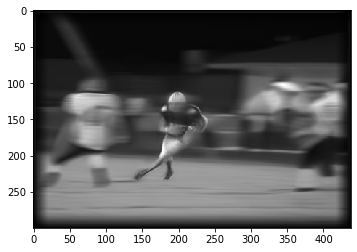

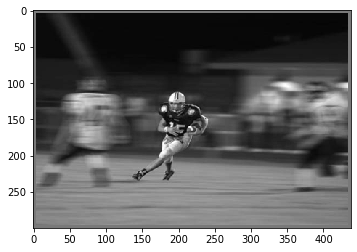

In [8]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')

In [31]:
ss = img.shape
b = np.ones(ss).ravel()
beta = 10

itera = 1
noiseSD = 0.01
patchSize = 21
alpha = 4/3
betas = 50*np.array([1])
T = 10
h = 10
stride = 1
K=cv2.getGaussianKernel(5,1)
K = K@K.T
lam = 64/(noiseSD**2)
noiseI = np.float32(x)

def call_func(x):
    global ss, K, b, magnitude, directions
    img = x.reshape(ss)
    outp = myConvolve(img, magnitude, directions)
    outp = myConvolve(outp, np.rot90(np.rot90(magnitude)), np.rot90(np.rot90(directions)))
#     outp = convolve2d(img, np.rot90(np.rot90(K)), 'same')
    cost = np.mean(np.power(outp.ravel() - b, 2))
    global itera
    
    print("      Iter ->     ", itera, ' cost -- > ', cost)
    itera += 1

def myConvolve(img, K_mag, K_dir, patch_size=30):
    outp = np.zeros(img.shape)
    pd = patch_size // 2
    img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    for i in range(pd, img.shape[0]-pd):
        for j in range(pd, img.shape[1]-pd):
            o = utils.linearBlur(img[i-pd:i+pd,j-pd:j+pd], int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])[15,15]
            outp[i-pd,j-pd] = o
    return outp
    
def make_mv(x, k_mag, k_dir, ss, lam, beta, patch_size = 30):
    def mv(x):
        K_mag = magnitude
        K_dir = directions
        img = x.reshape(ss)
        outp = myConvolve(img, K_mag, K_dir)
#         outp = np.zeros(img.shape)
#         foutp = np.zeros(img.shape)
#         pd = patch_size // 2
#         img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
#         for i in range(pd, img.shape[0]-pd):
#             for j in range(pd, img.shape[1]-pd):
#                 o = utils.linearBlur(img[i-pd:i+pd,j-pd:j+pd], int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])[15,15]
#                 outp[i-pd,j-pd] = o
#         outp = np.pad(outp, ((pd, pd), (pd, pd)), 'reflect')

        K_mag = np.rot90(np.rot90(K_mag))
        K_dir = np.rot90(np.rot90(K_dir))

        foutp = myConvolve(outp, K_mag, K_dir)
        
#         for i in range(pd, img.shape[0]-pd):
#             for j in range(pd, img.shape[1]-pd):
#                 foutp[i-pd,j-pd] = utils.linearBlur(outp[i-pd:i+pd,j-pd:j+pd], int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])[15,15]
        foutp *= lam
        return foutp.ravel() + beta*x
    return mv

def mv(x):
    print("mat vec called")
    global ss, K, lam, beta
    print(beta)
    img = x.reshape(ss)
    print(ss)
    outp = convolve2d(img, K, 'same')
#     outp = outp[(K.shape[0]):-(K.shape[0]), (K.shape[1]):-(K.shape[1])]
#     print(outp.shape)
    outp = convolve2d(img, np.rot90(np.rot90(K)), 'same')
    print(outp.shape)
    outp *= lam
    return outp.ravel() + beta*x


def rmv(x):
    print("mat vec called")
    global ss, K, lam, beta
    print(beta)
    img = x.reshape(ss)
    print(ss)
    outp = convolve2d(img, K, 'same')
#     outp = outp[(K.shape[0]):-(K.shape[0]), (K.shape[1]):-(K.shape[1])]
#     print(outp.shape)
    outp = convolve2d(img, np.rot90(np.rot90(K)), 'same')
    print(outp.shape)
    outp *= lam
    return outp.ravel() + beta*x
func = make_mv(x, magnitude, directions, ss, lam, beta)
A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=func, rmatvec=func)

In [39]:
from scipy.optimize import fmin_bfgs

def EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, T, alpha, h, stride):
    global z, x, A, beta
    beta = np.abs(betas[0]/4)
    cleanI = noiseI
    for betaa in betas:
        beta = betaa
        for tt in range(T):
            print("Iteration -> ", tt)
            I1 = z
            tt1 = noiseI
#             I1 = getPrior(cleanI, patchSize, alpha, h, stride)
#             tt1 = noiseI[(K.shape[0]//2):-(K.shape[0]//2),(K.shape[1]//2):-(K.shape[1]//2)]
#             tt1 = convolve2d(tt1, np.rot90(np.rot90(K)), 'full')
            tt1 = myConvolve(tt1, np.rot90(np.rot90(magnitude)), np.rot90(np.rot90(directions)))
            tt2 = I1
            x0 = I1.ravel()
            cleanI = bicgstab(A, lam*tt1.ravel() + beta*tt2.ravel(), callback=call_func, maxiter=10)
            cleanI = np.reshape(cleanI[0], noiseI.shape)
            arr = plt.subplots(1,3, figsize = (15,15))[1]
            arr[0].imshow(z, cmap='gray')
            arr[1].imshow(x, cmap='gray')
            arr[2].imshow(cleanI, cmap='gray')
            
            print(np.sum(cleanI-z), np.sum(z), np.sum(cleanI[30:-30,30:-30]-x[30:-30,30:-30]))
    return cleanI

Iteration ->  0
      Iter ->      1  cost -- >  17465.568485540334
      Iter ->      2  cost -- >  16924.803310502284
      Iter ->      3  cost -- >  16466.90095890411
      Iter ->      4  cost -- >  16310.392397260273
      Iter ->      5  cost -- >  16256.519566210045
      Iter ->      6  cost -- >  16287.062070015221
      Iter ->      7  cost -- >  16171.222450532725
      Iter ->      8  cost -- >  16337.817534246575
      Iter ->      9  cost -- >  16435.789178082192
      Iter ->      10  cost -- >  16285.335159817352
703527471752.7654 9255911.442176871 486617531187.81116


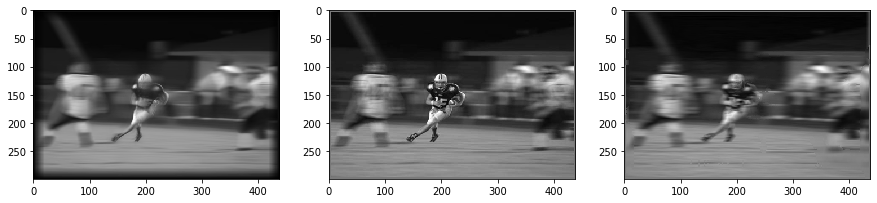

In [40]:

cleanI = EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, 1, alpha, h, stride)

In [99]:
K = [[2, 1], [1, 1]]
ss = (2, 2)
def mv(x):
    global K, ss
    img = x.reshape(ss)
    print(img)
    outp = convolve2d(img, K, 'same')
    outp = convolve2d(img, K, 'same')
    return outp.ravel()

A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

x = convolve2d(inp, K, 'same')
x = convolve2d(x, K, 'same')
b = x.ravel()

bicg(A, b)

[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[ 8. 20.]
 [20. 52.]]
[[ 8. 20.]
 [20. 52.]]
[[ 2.32404545  2.94194642]
 [ 2.94194642 -2.10270779]]
[[ 2.32404545  2.94194642]
 [ 2.94194642 -2.10270779]]
[[ 2.06676326  1.30685564]
 [ 1.30685564 -6.67833719]]
[[ 2.06676326  1.30685564]
 [ 1.30685564 -6.67833719]]
[[ 0.38481549 -1.88812176]
 [-1.88812176 -8.09730044]]
[[ 0.38481549 -1.88812176]
 [-1.88812176 -8.09730044]]
[[-1.42407488 -4.00198644]
 [-4.00198644 -4.69346456]]
[[-1.42407488 -4.00198644]
 [-4.00198644 -4.69346456]]
[[-2.75363481 -5.44133821]
 [-5.44133821 -1.29695297]]
[[-2.75363481 -5.44133821]
 [-5.44133821 -1.29695297]]
[[-4.55784663 -7.61361924]
 [-7.61361924  2.97504913]]
[[-4.55784663 -7.61361924]
 [-7.61361924  2.97504913]]
[[ -7.28288423 -10.69049377]
 [-10.69049377  10.41024542]]
[[ -7.28288423 -10.69049377]
 [-10.69049377  10.41024542]]
[[-10.39808732 -13.41098151]
 [-13.41098151  22.00764773]]
[[-10.39808732 -13.41098151]
 [-13.41098151  22.00764773]]
[[-12.65405571 -13.9

(array([ 7.51013151, 15.53539489, 15.53539489, 14.65715236]), 40)

In [87]:
# K=cv2.getGaussianKernel(5,1)
# K = K@K.T
# ss = img.shape
# itera = 1
# b = np.ones(ss).ravel()
# def call_func(x):
#     global ss, K, b
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     cost = np.mean(np.power(outp.ravel() - b, 2))
#     global itera
#     print("      Iter ->     ", itera, "cost->       ", cost)
#     itera += 1
    
# def mv(x):
#     global ss, K
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     return outp.ravel()

# A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

# x0 = np.zeros(ss).ravel()

# # x = bicg(A, b, x0, callback=call_func, maxiter=100)